In [1]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
data_import = pd.read_csv('/Users/sitanshurupani/Data Science Coursework/Sem 4/GQP - National Parks/DataSpell Project/Data/Daily_attendance.csv')

In [4]:
all_years_test = data_import
all_years_test.set_index('Full_Date', inplace=True)

In [5]:
all_years_test.index = pd.to_datetime(all_years_test.index)
ds = all_years_test.index.to_series()
all_years_test['YEAR'] = ds.dt.year
all_years_test['MONTH'] = ds.dt.month
all_years_test['DAY_OF_WEEK'] = ds.dt.dayofweek
all_years_test['DAY'] = ds.dt.day

In [6]:
all_years_test.drop(columns=['snow_1h'], inplace=True)
all_years_test["federal_holiday_flag"] = all_years_test["federal_holiday_flag"].astype(int)
all_years_test["school_holiday_flag"] = all_years_test["school_holiday_flag"].astype(int)

In [7]:
all_years_test.isna().sum()

value                   0
temp                    0
temp_min                0
temp_max                0
pressure                0
humidity                0
wind_speed              0
wind_gust               3
rain_1h                 0
federal_holiday_flag    0
school_holiday_flag     0
YEAR                    0
MONTH                   0
DAY_OF_WEEK             0
DAY                     0
dtype: int64

In [8]:
all_years_test['wind_gust'].fillna((all_years_test['wind_gust'].mean()), inplace=True)

In [9]:
# df_standard_scale = StandardScaler()
# x_standard = df_standard_scale.fit_transform(all_years_test)

In [10]:
mask = np.random.rand(len(all_years_test)) < 0.8
df_train = all_years_test[mask]
df_test = all_years_test[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=375
Testing data set length=85


In [11]:
expr = """value ~ DAY  + DAY_OF_WEEK + MONTH + YEAR + temp + temp_min + temp_max + pressure + humidity + wind_speed + wind_gust + rain_1h + federal_holiday_flag + school_holiday_flag"""

In [12]:
# X_train, X_test, y_train, y_test = train_test_split(all_years_test.loc[:, all_years_test.columns != 'value'], all_years_test['value'], test_size =0.2, random_state = 42)

In [13]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [14]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [15]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  value   No. Observations:                  375
Model:                            GLM   Df Residuals:                      360
Model Family:                 Poisson   Df Model:                           14
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23931.
Date:                Wed, 06 Apr 2022   Deviance:                       44524.
Time:                        12:27:31   Pearson chi2:                 4.29e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              370.2147 

In [16]:
print(poisson_training_results.mu)

[ 802.67887939  579.43951343  582.55399259  649.53236881  857.28465561
  805.6135584   762.26092255  883.6431774   549.27968106  861.13503939
 1068.957236    699.09777034  586.49362703  616.53559894  786.90416725
  683.60917483  844.08690085  696.7067152   985.03590933  884.9726556
  737.51658682 1125.83809098  925.51163797  972.07992125  785.03061576
  845.88040175  999.16775174 1210.67342498 1166.63017046 1063.28805284
 1271.62958491 1208.14361313 1152.64579439 1479.34764064 1584.31838807
 1619.54776937 1367.34543441 1596.02620406  876.94773936  891.50613591
 1597.11482889 1319.60762271  941.5554486   661.68760628 1711.1663524
 2136.21431669 1459.65160615  829.62810023 1079.86035042 1546.96599937
 1556.74787704 1532.3813776  2332.62914482 2218.2976203  1820.47083579
 1780.80429872 1956.86079064 1879.46925703 1502.66853474 1355.61905264
 1821.06467854 1846.7169464  1923.20913461 1625.20896405 1743.95372731
 1866.90558836 2583.02526785 2474.05002445 1701.15756085 1412.71205638
 1945.90

In [17]:
mu_glm = poisson_training_results.mu

In [18]:
df_train['Value_LAMBDA'] = mu_glm

/var/folders/90/98s1yvbs2zq9h146qcbc3t_h0000gn/T/ipykernel_39216/2113704252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Value_LAMBDA'] = mu_glm


In [19]:
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['value'] - x['Value_LAMBDA'])**2 - x['Value_LAMBDA']) / x['Value_LAMBDA'], axis=1)

/var/folders/90/98s1yvbs2zq9h146qcbc3t_h0000gn/T/ipykernel_39216/1666380816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['value'] - x['Value_LAMBDA'])**2 - x['Value_LAMBDA']) / x['Value_LAMBDA'], axis=1)


In [20]:
ols_expr = """AUX_OLS_DEP ~ Value_LAMBDA - 1"""

In [21]:
aux_olsr_results = smf.ols(ols_expr, df_train).fit()

In [22]:
print(aux_olsr_results.params)

Value_LAMBDA    0.071668
dtype: float64


In [23]:
aux_olsr_results.tvalues

Value_LAMBDA    9.501254
dtype: float64

In [24]:
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

In [25]:
print(nb2_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  value   No. Observations:                  375
Model:                            GLM   Df Residuals:                      360
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2824.5
Date:                Wed, 06 Apr 2022   Deviance:                       639.13
Time:                        12:27:43   Pearson chi2:                     552.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              335.5659 

In [26]:
nb2_predictions = nb2_training_results.get_prediction(X_test)

In [27]:
predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame)

                   mean    mean_se  mean_ci_lower  mean_ci_upper
Full_Date                                                       
2019-05-06   701.267735  36.700406     632.902425     777.017777
2019-05-19   774.108016  41.420364     697.037496     859.700122
2019-05-21   806.534300  44.157215     724.469531     897.895012
2019-05-29   639.821977  37.464706     570.449417     717.630959
2019-06-11   668.771058  48.672931     579.865553     771.307634
...                 ...        ...            ...            ...
2021-10-02  1329.882599  59.033381    1219.069696    1450.768346
2021-10-15  1256.981396  64.514339    1136.687509    1390.005801
2021-10-17  1463.566607  79.800174    1315.228437    1628.635113
2021-10-23  1490.332423  72.577264    1354.661332    1639.591150
2021-10-27  1340.067225  99.496326    1158.583126    1549.979564

[85 rows x 4 columns]


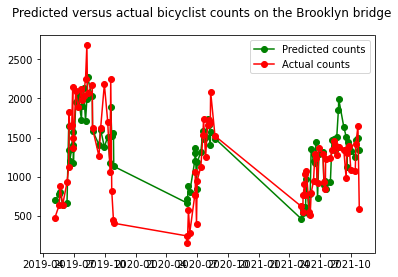

In [28]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

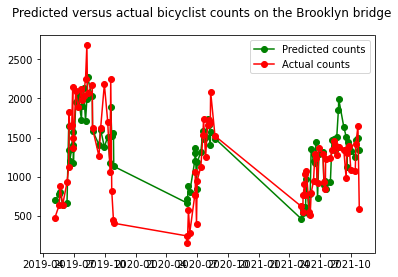

In [29]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

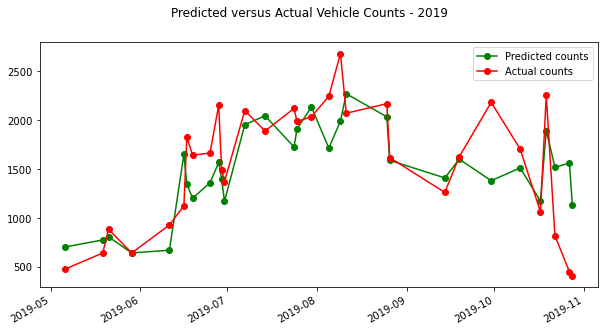

In [30]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
predicted_counts = predicted_counts[predicted_counts.index.year==2019]
actual_counts = actual_counts[actual_counts.index.year==2019]
fig = plt.figure(figsize=(10,5))
fig.suptitle('Predicted versus Actual Vehicle Counts - 2019')
predicted, = plt.plot(predicted_counts.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(actual_counts.index, actual_counts, 'ro-', label='Actual counts')
fig.autofmt_xdate()
plt.legend(handles=[predicted, actual])
plt.show()

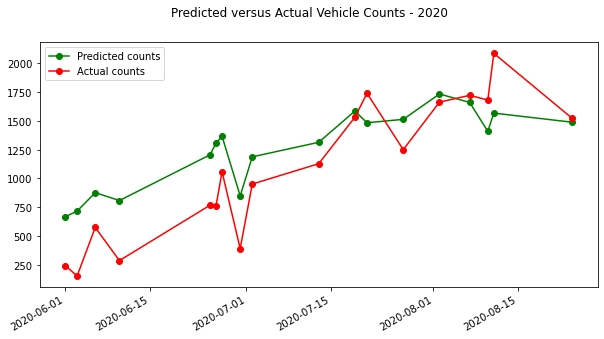

In [31]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
predicted_counts = predicted_counts[predicted_counts.index.year==2020]
actual_counts = actual_counts[actual_counts.index.year==2020]
fig = plt.figure(figsize=(10,5))
fig.suptitle('Predicted versus Actual Vehicle Counts - 2020')
predicted, = plt.plot(predicted_counts.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(actual_counts.index, actual_counts, 'ro-', label='Actual counts')
fig.autofmt_xdate()
plt.legend(handles=[predicted, actual])
plt.show()

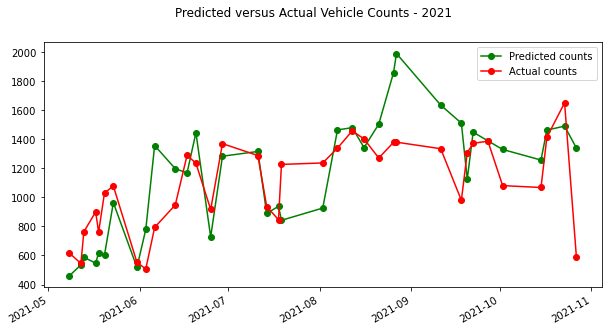

In [32]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
predicted_counts = predicted_counts[predicted_counts.index.year==2021]
actual_counts = actual_counts[actual_counts.index.year==2021]
fig = plt.figure(figsize=(10,5))
fig.suptitle('Predicted versus Actual Vehicle Counts - 2021')
predicted, = plt.plot(predicted_counts.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(actual_counts.index, actual_counts, 'ro-', label='Actual counts')
fig.autofmt_xdate()
plt.legend(handles=[predicted, actual])
plt.show()

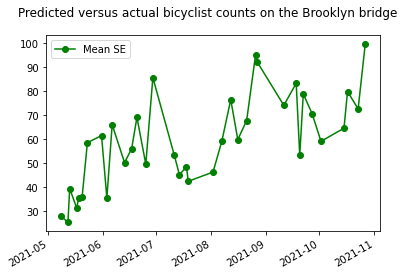

In [33]:
predicted_mean_se=predictions_summary_frame['mean_se']
predicted_mean_se = predicted_mean_se[predicted_mean_se.index.year==2021]
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(predicted_mean_se.index, predicted_mean_se, 'go-', label='Mean SE')
fig.autofmt_xdate()
plt.legend(handles=[predicted])
plt.show()

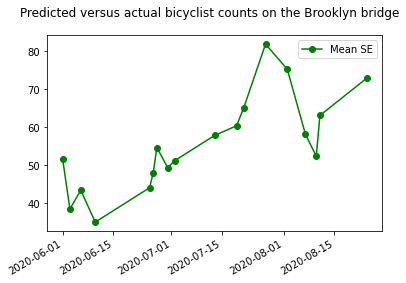

In [34]:
predicted_mean_se=predictions_summary_frame['mean_se']
predicted_mean_se = predicted_mean_se[predicted_mean_se.index.year==2020]
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(predicted_mean_se.index, predicted_mean_se, 'go-', label='Mean SE')
fig.autofmt_xdate()
plt.legend(handles=[predicted])
plt.show()

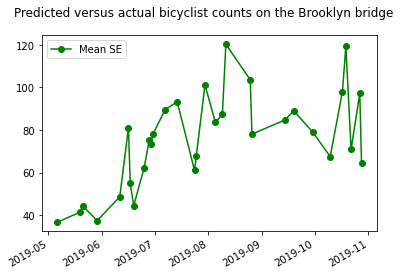

In [35]:
predicted_mean_se=predictions_summary_frame['mean_se']
predicted_mean_se = predicted_mean_se[predicted_mean_se.index.year==2019]
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(predicted_mean_se.index, predicted_mean_se, 'go-', label='Mean SE')
fig.autofmt_xdate()
plt.legend(handles=[predicted])
plt.show()

In [36]:
from statsmodels.tools.eval_measures import rmse
rmse = rmse(y_test, predictions_summary_frame['mean'])

<Figure size 432x288 with 0 Axes>

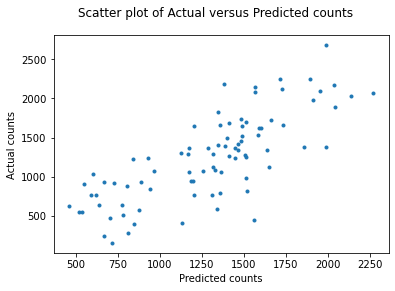

In [37]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()